In [1]:
import os
os.chdir('/pc_win_loss')

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import lightgbm as lgb

from functions.visualizer import *
from src.config import *

## データ取り込み

In [3]:
df = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
df.head()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0


## 特徴量エンジニアリング

In [4]:
df_prep = df.drop(COL_ID, axis=1)
# df_prep['blueHerald'] = df_prep[COL_ELITEMONSTERS] - df_prep[COL_DRAGONS]
# df_prep = df_prep.drop([COL_FIRSTBLOOD, COL_ELITEMONSTERS, COL_DRAGONS], axis=1)

df_prep.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,5,8,6,0,0,14536,17256,0
1,1,10,1,5,0,0,14536,17863,0
2,0,3,10,2,0,0,17409,17256,0
3,1,7,10,8,0,0,19558,18201,0
4,0,4,9,4,0,0,17409,17256,0


## モデル構築

In [5]:
random_state = 0

In [6]:
# 20%の被験者を選ぶ
df_train, df_val = train_test_split(df_prep, test_size=0.2, random_state=random_state)

print(len(df_train))
print(len(df_val))

6400
1600


### LightGBM実装

In [7]:
feature_cols = list(df_train.drop(COL_BLUEWINS, axis=1).columns)

train_x = df_train.drop(COL_BLUEWINS, axis=1)
train_y = df_train[COL_BLUEWINS]

val_x = df_val.drop(COL_BLUEWINS, axis=1)
val_y = df_val[COL_BLUEWINS]

In [8]:
train_x.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
1001,1,11,3,8,1,1,18274,18472
7360,0,6,11,7,0,0,20619,17256
5234,1,6,3,5,1,0,16961,18201
7390,0,9,5,8,0,0,18117,18472
6841,1,9,4,9,0,0,14536,17256


In [9]:
model = lgb.LGBMClassifier(random_state=random_state)
model.fit(train_x, train_y)

LGBMClassifier(random_state=0)

In [10]:
# 検証データを用いて予測
pred_y = model.predict(val_x)

accuracy = accuracy_score(pred_y, val_y)
print(f"accuracy score: {accuracy:0.4f}")

accuracy score: 0.8069


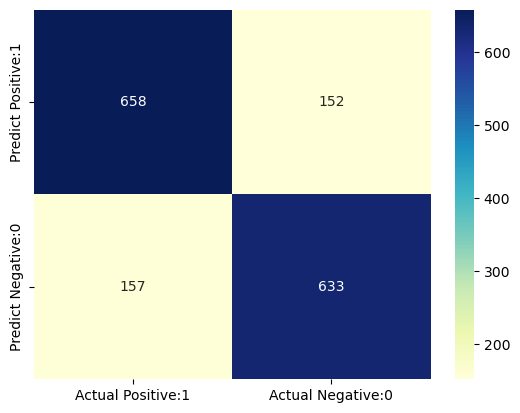

In [11]:
cm = confusion_matrix(val_y, pred_y)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.show()

### 変数重要度の確認

In [12]:
df_importance = pd.DataFrame(model.feature_importances_, index=feature_cols, columns=['importance'])
df_importance['importance'] = df_importance['importance'] / sum(df_importance['importance'])
display(df_importance)

,importance
blueFirstBlood,0.040333
blueKills,0.160667
blueDeaths,0.180333
blueAssists,0.172667
blueEliteMonsters,0.060333
blueDragons,0.035333
blueTotalGold,0.200000
blueTotalExperience,0.150333


In [13]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot.index                         # 特徴量のカラム名を取得
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

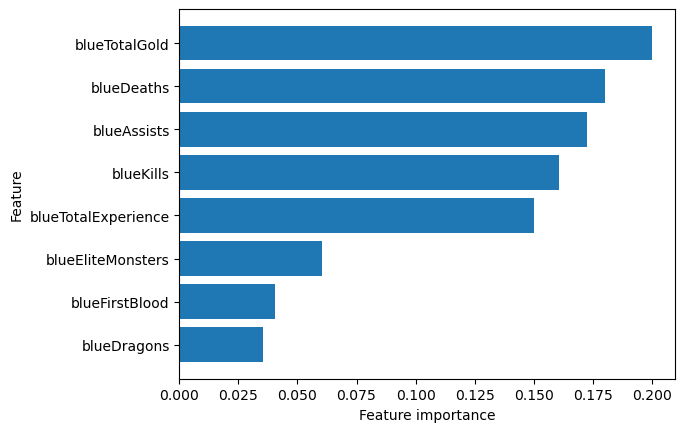

In [14]:
plot_feature_importance(df_importance)

In [15]:
# 前処理後のデータフレームをpickle形式で保存
path = 'output/df_prep.pkl'
pd.to_pickle(df_prep, path)

In [16]:
# # 確認用
# df_prep = pd.read_pickle(path)
# df_prep.head()